# Nama: Maximilian Sulistiyo
# NIM: 13522061

# 1 Import Libraries and Images

Import libraries

In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 2 Creating a Synthetic 3D Checkerboard

In [40]:
def create_3d_checkerboard(rows=7, cols=7, square_size=1.0):
    """Create 3D checkerboard corner points"""
    pattern_rows, pattern_cols = rows - 1, cols - 1
    objp = np.zeros((pattern_rows * pattern_cols, 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_cols, 0:pattern_rows].T.reshape(-1, 2)
    objp *= square_size
    objp -= objp.mean(axis=0)  
    return objp

In [ ]:
def visualize_3d_checkerboard(points_3d, title="3D Checkerboard Pattern"):
    """
    Visualize 3D checkerboard points
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot points
    ax.scatter(
        points_3d[:, 0],
        points_3d[:, 1],
        points_3d[:, 2],
        c="red",
        marker="o",
        s=100,
        label="Corners",
    )

    # Draw grid lines
    rows = int(np.sqrt(len(points_3d)))
    for i in range(rows):
        row_points = points_3d[i * rows : (i + 1) * rows]
        ax.plot(row_points[:, 0], row_points[:, 1], row_points[:, 2], "b-", alpha=0.3)

    for j in range(rows):
        col_points = points_3d[j::rows]
        ax.plot(col_points[:, 0], col_points[:, 1], col_points[:, 2], "b-", alpha=0.3)

    ax.set_xlabel("X (world units)", fontweight="bold")
    ax.set_ylabel("Y (world units)", fontweight="bold")
    ax.set_zlabel("Z (world units)", fontweight="bold")
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# 3 Projection Functions

In [ ]:
def define_camera_intrinsic(fx=800, fy=800, cx=320, cy=240):
    """
    Define camera intrinsic matrix K
    """
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float32)

    print("Camera Intrinsic Matrix (K):")
    print(K)
    print(f"\nParameters: fx={fx}, fy={fy}, cx={cx}, cy={cy}\n")

    return K

In [ ]:
def define_camera_extrinsic(rotation_deg=(0, 0, 0), translation=(0, 0, 5)):
    """
    Define camera extrinsic parameters (R and t)
    """
    # Convert angles to radians
    rx, ry, rz = np.radians(rotation_deg)

    # Rotation matrices for each axis
    Rx = np.array(
        [[1, 0, 0], [0, np.cos(rx), -np.sin(rx)], [0, np.sin(rx), np.cos(rx)]]
    )

    Ry = np.array(
        [[np.cos(ry), 0, np.sin(ry)], [0, 1, 0], [-np.sin(ry), 0, np.cos(ry)]]
    )

    Rz = np.array(
        [[np.cos(rz), -np.sin(rz), 0], [np.sin(rz), np.cos(rz), 0], [0, 0, 1]]
    )

    # Combined rotation: R = Rz * Ry * Rx
    R = Rz @ Ry @ Rx

    # Translation vector
    t = np.array(translation).reshape(3, 1)

    print("Camera Extrinsic Parameters:")
    print(f"\nRotation Matrix (R):")
    print(R)
    print(
        f"\nRotation angles: rx={rotation_deg[0]}°, ry={rotation_deg[1]}°, rz={rotation_deg[2]}°"
    )
    print(f"\nTranslation Vector (t):")
    print(t.T)
    print(f"Camera position: {translation}\n")

    return R, t

In [ ]:
def project_3d_to_2d(points_3d, K, R, t):
    """
    Project 3D world points to 2D image points
    Using formula: x = K [R|t] X
    """
    # Create projection matrix P = K [R|t]
    Rt = np.hstack([R, t]) 
    P = K @ Rt

    print("Projection Matrix P = K[R|t]:")
    print(P)
    print()

    # Convert 3D points to homogeneous coordinates (add 1)
    points_3d_homogeneous = np.hstack(
        [points_3d, np.ones((len(points_3d), 1))]
    )  # (N, 4)

    # Project: x = P @ X
    points_2d_homogeneous = (P @ points_3d_homogeneous.T).T

    # Normalize by dividing by z (third coordinate)
    points_2d = points_2d_homogeneous[:, :2] / points_2d_homogeneous[:, 2:3]

    print(f"Projected {len(points_2d)} points from 3D to 2D")
    print(
        f"2D point range: X=[{points_2d[:, 0].min():.1f}, {points_2d[:, 0].max():.1f}], "
        f"Y=[{points_2d[:, 1].min():.1f}, {points_2d[:, 1].max():.1f}]\n"
    )

    return points_2d, P

In [110]:
def assemble_projection_matrix(K, R, t):
    """Build P = K [R | t]."""
    Rt = np.hstack([R, t.reshape(3, 1)])
    P = K @ Rt
    return P

def save_camera_matrices_txt(K, R, t, filepath, meta: dict | None = None):
    """
    Save camera matrices to a TXT file:
      - Intrinsic K
      - Rotation R
      - Translation t
    """
    p = Path(filepath)
    p.parent.mkdir(parents=True, exist_ok=True)
    if p.suffix.lower() != ".txt":
        p = p.with_name(p.name + ".txt")

    # Ensure shapes
    K = np.asarray(K, dtype=np.float64)
    R = np.asarray(R, dtype=np.float64)
    t = np.asarray(t, dtype=np.float64).reshape(3, 1)

    # Derived quantities (kept in case you need them later)
    P = assemble_projection_matrix(K, R, t)
    C = -R.T @ t  # camera center in world coordinates

    # Pretty string for matrices
    def mat_str(A):
        return np.array2string(A, precision=6, suppress_small=False, max_line_width=200)

    with p.open("w", encoding="utf-8") as f:
        f.write("# Camera Matrices\n")
        if meta:
            for k, v in meta.items():
                f.write(f"# {k}: {v}\n")
        f.write("\n[K] Intrinsic (3x3):\n")
        f.write(mat_str(K) + "\n")

        f.write("\n[R] Rotation (3x3):\n")
        f.write(mat_str(R) + "\n")

        f.write("\n[t] Translation (3x1):\n")
        f.write(mat_str(t) + "\n")

    return str(p.resolve())
    

# 4 Testing

In [101]:
def visualize_projection(points_3d, points_2d, K, R, t, title="3D to 2D Projection", image_size=(1000, 1000), img_name="projection"):
    """
    Visualize both 3D points and their 2D projections
    """
    fig = plt.figure(figsize=(16, 6))
    
    # Plot 1: 3D checkerboard with camera
    ax1 = fig.add_subplot(131, projection='3d')
    
    # Plot checkerboard points
    ax1.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], 
                c='red', marker='o', s=50, label='3D Points')
    
    # Plot camera position
    camera_pos = -R.T @ t
    ax1.scatter(camera_pos[0], camera_pos[1], camera_pos[2], 
                c='blue', marker='^', s=200, label='Camera')
    
    # Draw camera viewing direction
    camera_direction = R.T @ np.array([[0], [0], [1]])
    ax1.quiver(camera_pos[0], camera_pos[1], camera_pos[2],
               camera_direction[0], camera_direction[1], camera_direction[2],
               length=2, color='blue', arrow_length_ratio=0.3)
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D World View', fontweight='bold')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: 2D projection
    ax2 = fig.add_subplot(132)
    ax2.scatter(points_2d[:, 0], points_2d[:, 1], c='green', marker='o', s=50)
    
    # Draw grid lines
    rows = int(np.sqrt(len(points_2d)))
    for i in range(rows):
        row_points = points_2d[i*rows:(i+1)*rows]
        ax2.plot(row_points[:, 0], row_points[:, 1], 'b-', alpha=0.3)
    
    for j in range(rows):
        col_points = points_2d[j::rows]
        ax2.plot(col_points[:, 0], col_points[:, 1], 'b-', alpha=0.3)
    
    ax2.set_xlim(0, image_size[0]) 
    ax2.set_ylim(image_size[1], 0) 
    
    ax2.set_xlabel('u (pixels)', fontweight='bold')
    ax2.set_ylabel('v (pixels)', fontweight='bold')
    ax2.set_title('2D Image Projection', fontweight='bold')
    ax2.grid(True)
    ax2.set_aspect('equal') 
    
    # Plot 3: Side by side comparison
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    
    info_text = f"""
    PROJECTION PARAMETERS
    
    Intrinsic Matrix K:
    fx = {K[0,0]:.1f} px
    fy = {K[1,1]:.1f} px
    cx = {K[0,2]:.1f} px
    cy = {K[1,2]:.1f} px
    
    Camera Position:
    tx = {t[0,0]:.2f}
    ty = {t[1,0]:.2f}
    tz = {t[2,0]:.2f}
    """
    
    ax3.text(0.1, 0.5, info_text, fontsize=11, family='monospace', 
             verticalalignment='center')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{img_name}.png", dpi=150, bbox_inches='tight')
    plt.show()

In [106]:
def test_projections(points_3d, fx=800, fy=800, cx=500, cy=500, rotation_deg=(0, 0, 0), translation=(0, 0, 8), img_name="projection"):
    K = define_camera_intrinsic(fx, fy, cx, cy)
    R, t = define_camera_extrinsic(rotation_deg, translation)
    points_2d, P_true = project_3d_to_2d(points_3d, K, R, t)
    visualize_projection(points_3d, points_2d, K, R, t, img_name=img_name)
    save_camera_matrices_txt(K,R,t, f"{img_name}_matrices")

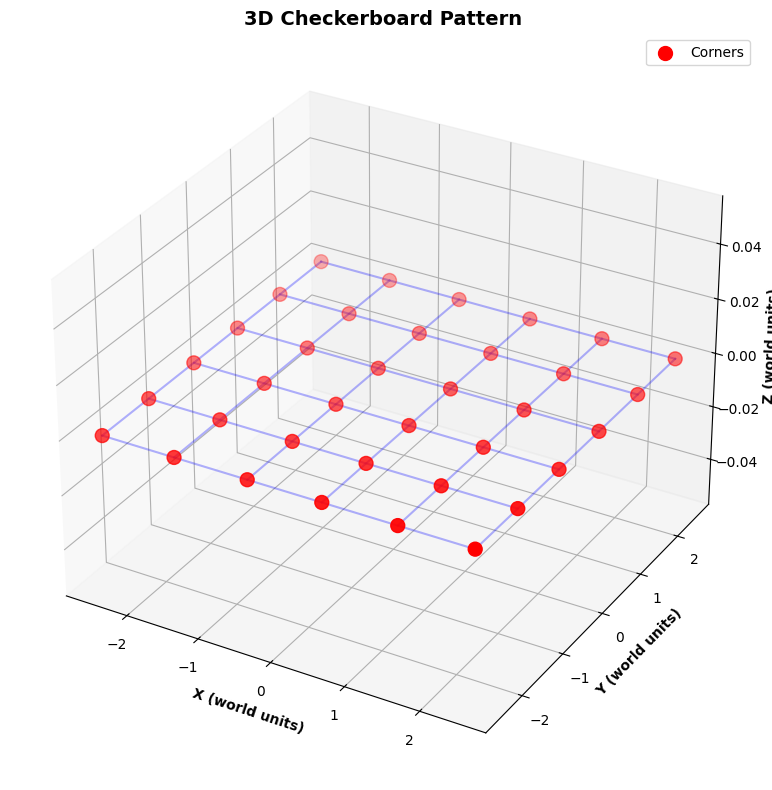

In [103]:
checker = create_3d_checkerboard()
visualize_3d_checkerboard(checker)

## 4.1 Test Focal Length

Camera Intrinsic Matrix (K):
[[800.   0. 500.]
 [  0. 800. 500.]
 [  0.   0.   1.]]

Parameters: fx=800, fy=800, cx=500, cy=500

Camera Extrinsic Parameters:

Rotation Matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Rotation angles: rx=0°, ry=0°, rz=0°

Translation Vector (t):
[[0 0 8]]
Camera position: (0, 0, 8)

Projection Matrix P = K[R|t]:
[[8.e+02 0.e+00 5.e+02 4.e+03]
 [0.e+00 8.e+02 5.e+02 4.e+03]
 [0.e+00 0.e+00 1.e+00 8.e+00]]

Projected 36 points from 3D to 2D
2D point range: X=[250.0, 750.0], Y=[250.0, 750.0]



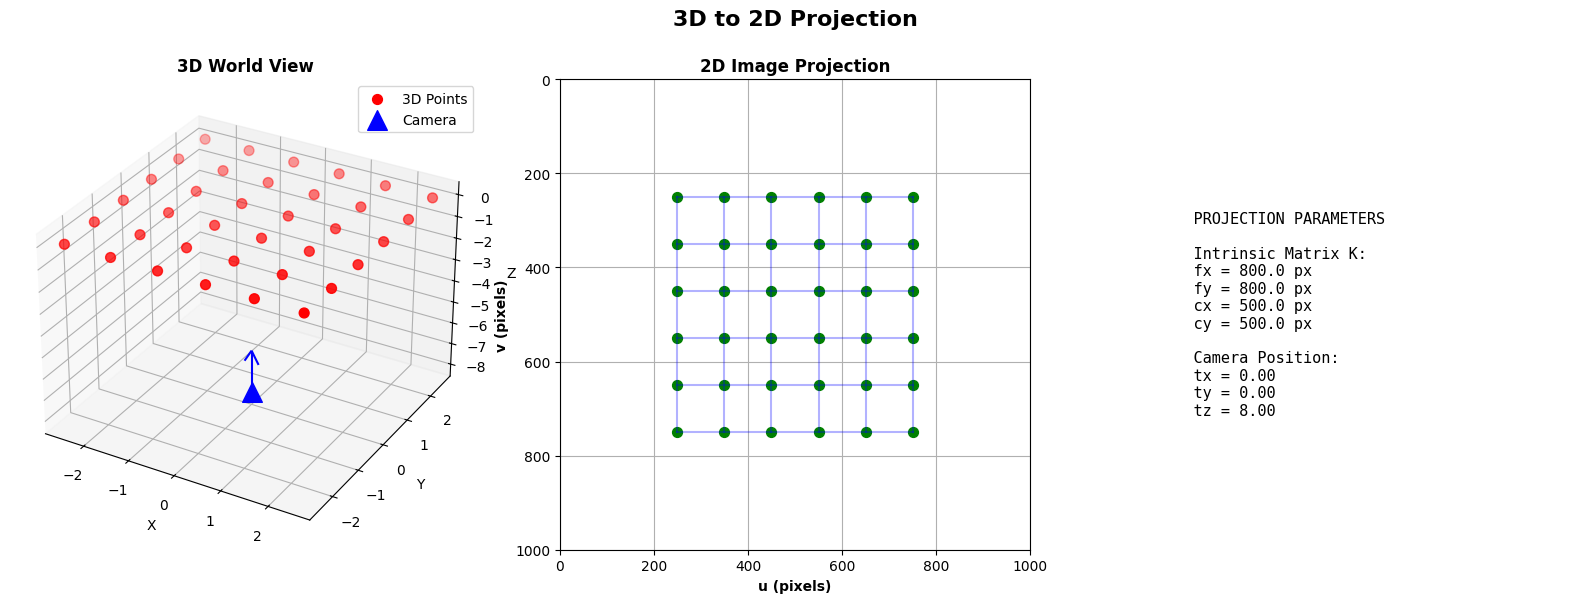

In [111]:
test_projections(checker, fx=800, fy=800, cx=500, cy=500, rotation_deg=(0, 0, 0), translation=(0, 0, 8), img_name="focal1")

Camera Intrinsic Matrix (K):
[[1.2e+03 0.0e+00 5.0e+02]
 [0.0e+00 1.2e+03 5.0e+02]
 [0.0e+00 0.0e+00 1.0e+00]]

Parameters: fx=1200, fy=1200, cx=500, cy=500

Camera Extrinsic Parameters:

Rotation Matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Rotation angles: rx=0°, ry=0°, rz=0°

Translation Vector (t):
[[0 0 8]]
Camera position: (0, 0, 8)

Projection Matrix P = K[R|t]:
[[1.2e+03 0.0e+00 5.0e+02 4.0e+03]
 [0.0e+00 1.2e+03 5.0e+02 4.0e+03]
 [0.0e+00 0.0e+00 1.0e+00 8.0e+00]]

Projected 36 points from 3D to 2D
2D point range: X=[125.0, 875.0], Y=[125.0, 875.0]



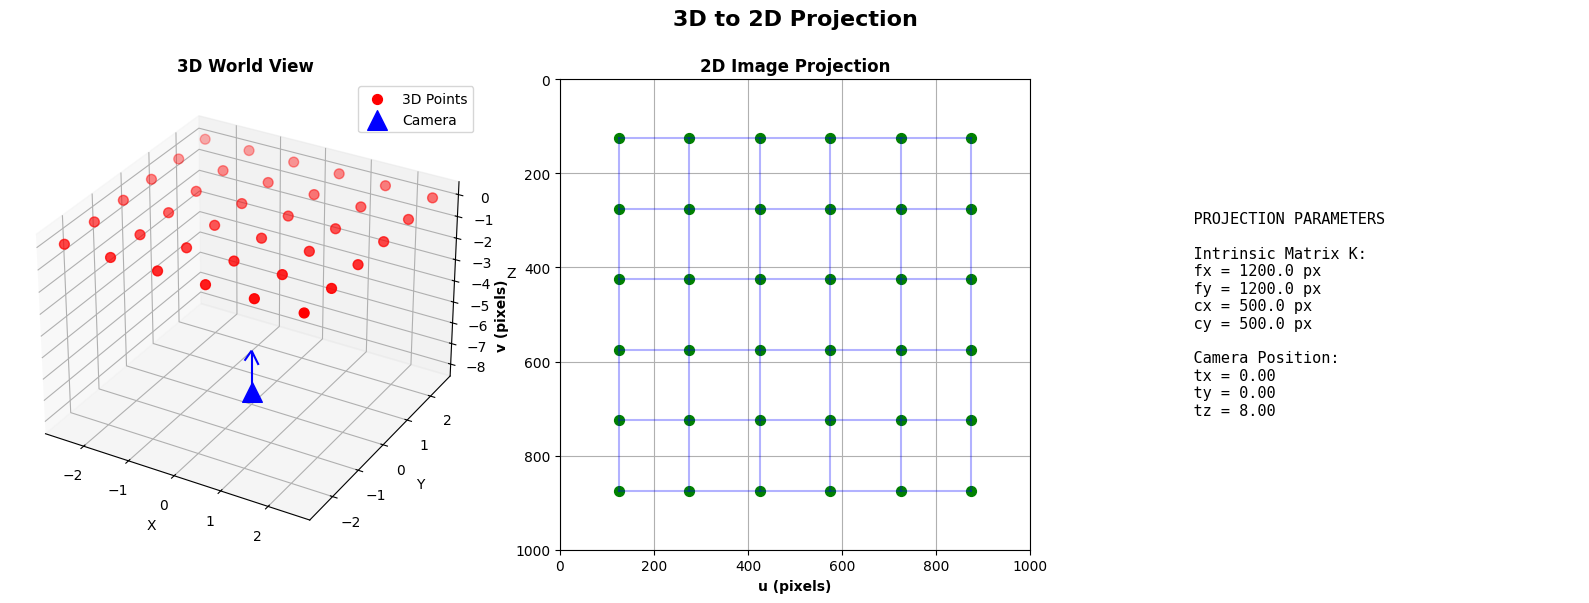

In [112]:
test_projections(checker, fx=1200, fy=1200, cx=500, cy=500, rotation_deg=(0, 0, 0), translation=(0, 0, 8), img_name="focal2")

## 4.2 Test Camera Distance

Camera Intrinsic Matrix (K):
[[800.   0. 500.]
 [  0. 800. 500.]
 [  0.   0.   1.]]

Parameters: fx=800, fy=800, cx=500, cy=500

Camera Extrinsic Parameters:

Rotation Matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Rotation angles: rx=0°, ry=0°, rz=0°

Translation Vector (t):
[[0 0 8]]
Camera position: (0, 0, 8)

Projection Matrix P = K[R|t]:
[[8.e+02 0.e+00 5.e+02 4.e+03]
 [0.e+00 8.e+02 5.e+02 4.e+03]
 [0.e+00 0.e+00 1.e+00 8.e+00]]

Projected 36 points from 3D to 2D
2D point range: X=[250.0, 750.0], Y=[250.0, 750.0]



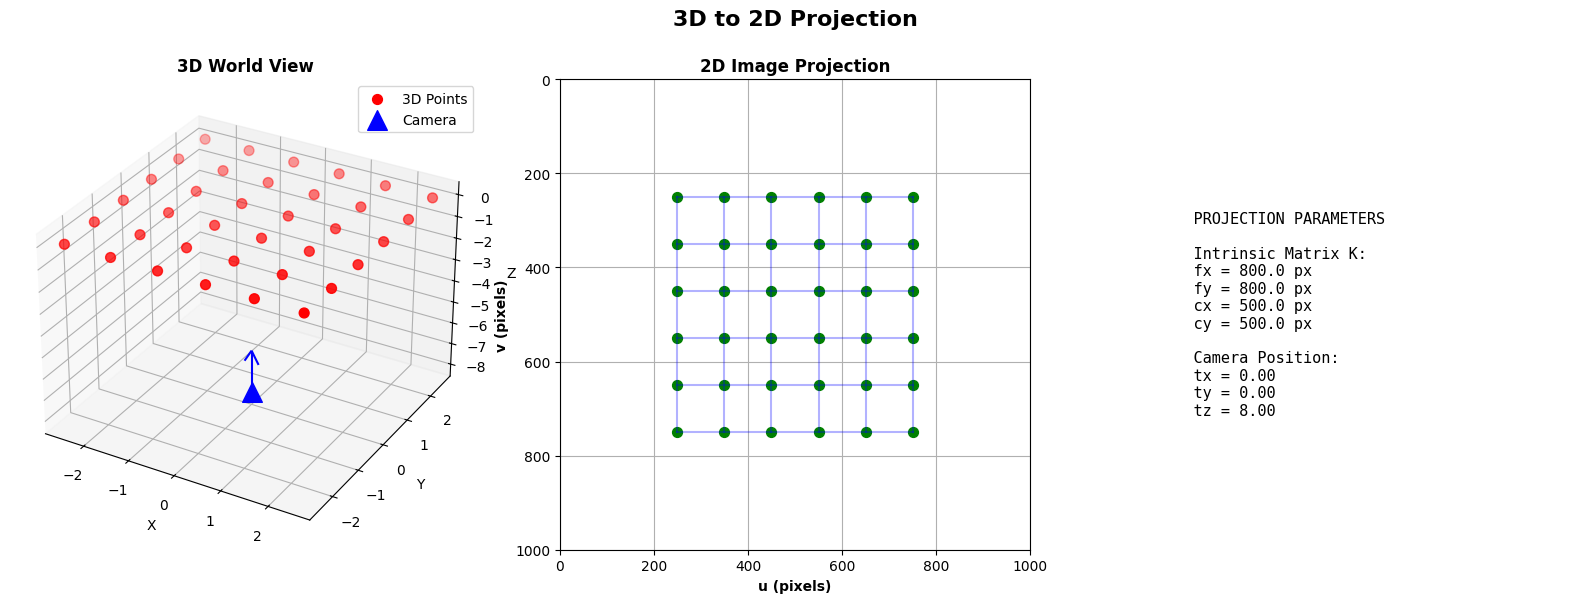

In [113]:
test_projections(checker, fx=800, fy=800, cx=500, cy=500, rotation_deg=(0, 0, 0), translation=(0, 0, 8), img_name="distance1")

Camera Intrinsic Matrix (K):
[[800.   0. 500.]
 [  0. 800. 500.]
 [  0.   0.   1.]]

Parameters: fx=800, fy=800, cx=500, cy=500

Camera Extrinsic Parameters:

Rotation Matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Rotation angles: rx=0°, ry=0°, rz=0°

Translation Vector (t):
[[ 0  0 16]]
Camera position: (0, 0, 16)

Projection Matrix P = K[R|t]:
[[8.0e+02 0.0e+00 5.0e+02 8.0e+03]
 [0.0e+00 8.0e+02 5.0e+02 8.0e+03]
 [0.0e+00 0.0e+00 1.0e+00 1.6e+01]]

Projected 36 points from 3D to 2D
2D point range: X=[375.0, 625.0], Y=[375.0, 625.0]



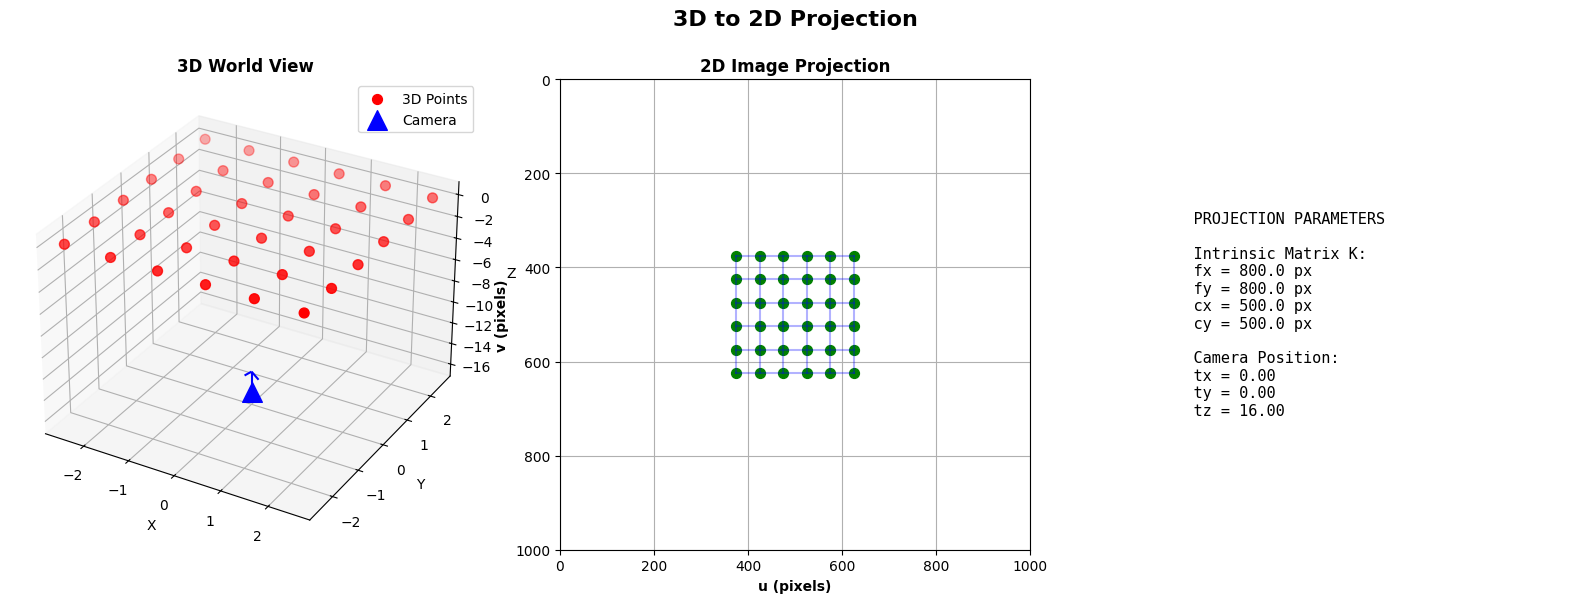

In [114]:
test_projections(checker, fx=800, fy=800, cx=500, cy=500, rotation_deg=(0, 0, 0), translation=(0, 0, 16), img_name="distance2")

## 4.3 Testing Viewing Angle

Camera Intrinsic Matrix (K):
[[800.   0. 500.]
 [  0. 800. 500.]
 [  0.   0.   1.]]

Parameters: fx=800, fy=800, cx=500, cy=500

Camera Extrinsic Parameters:

Rotation Matrix (R):
[[ 1.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678]
 [ 0.          0.70710678  0.70710678]]

Rotation angles: rx=45°, ry=0°, rz=0°

Translation Vector (t):
[[0 0 8]]
Camera position: (0, 0, 8)

Projection Matrix P = K[R|t]:
[[ 8.00000000e+02  3.53553391e+02  3.53553391e+02  4.00000000e+03]
 [ 0.00000000e+00  9.19238816e+02 -2.12132034e+02  4.00000000e+03]
 [ 0.00000000e+00  7.07106781e-01  7.07106781e-01  8.00000000e+00]]

Projected 36 points from 3D to 2D
2D point range: X=[179.1, 820.9], Y=[273.1, 644.8]



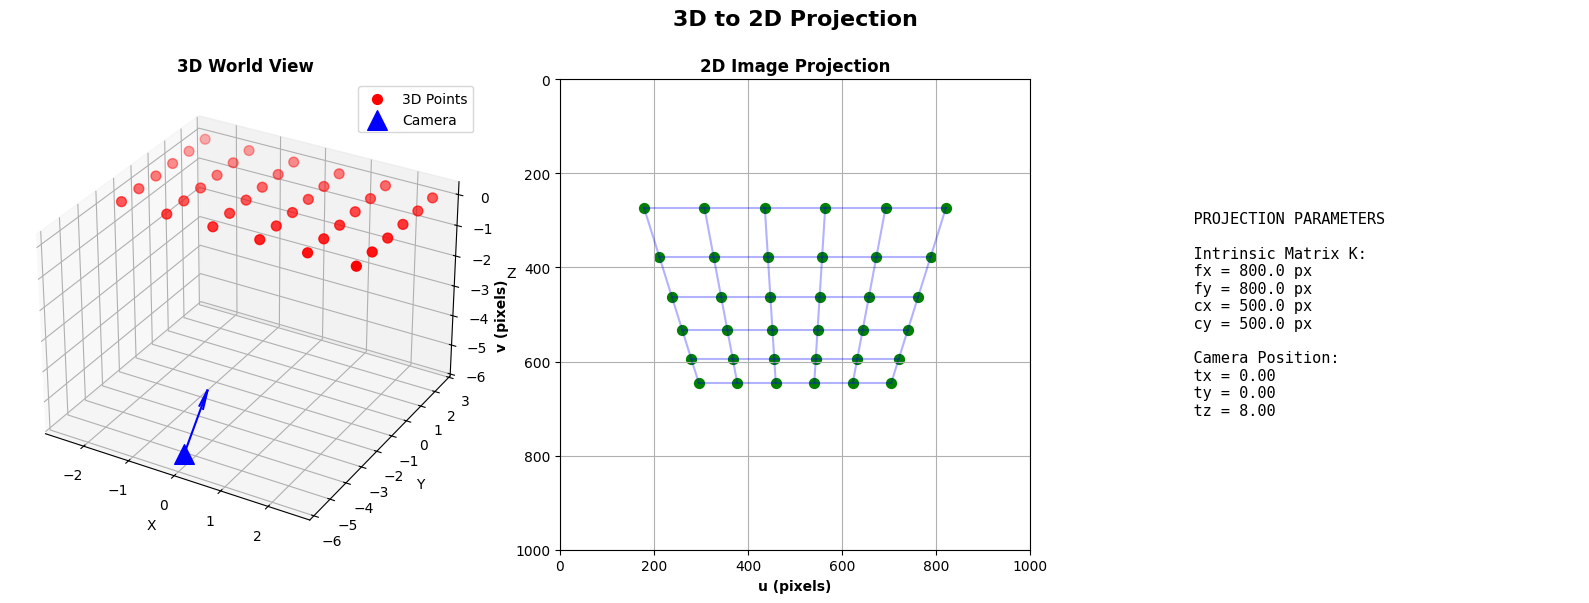

In [115]:
test_projections(checker, fx=800, fy=800, cx=500, cy=500, rotation_deg=(45, 0, 0), translation=(0, 0, 8), img_name="angle1")

Camera Intrinsic Matrix (K):
[[800.   0. 500.]
 [  0. 800. 500.]
 [  0.   0.   1.]]

Parameters: fx=800, fy=800, cx=500, cy=500

Camera Extrinsic Parameters:

Rotation Matrix (R):
[[ 0.70710678  0.          0.70710678]
 [ 0.          1.          0.        ]
 [-0.70710678  0.          0.70710678]]

Rotation angles: rx=0°, ry=45°, rz=0°

Translation Vector (t):
[[0 0 8]]
Camera position: (0, 0, 8)

Projection Matrix P = K[R|t]:
[[ 2.12132034e+02  0.00000000e+00  9.19238816e+02  4.00000000e+03]
 [-3.53553391e+02  8.00000000e+02  3.53553391e+02  4.00000000e+03]
 [-7.07106781e-01  0.00000000e+00  7.07106781e-01  8.00000000e+00]]

Projected 36 points from 3D to 2D
2D point range: X=[355.2, 726.9], Y=[179.1, 820.9]



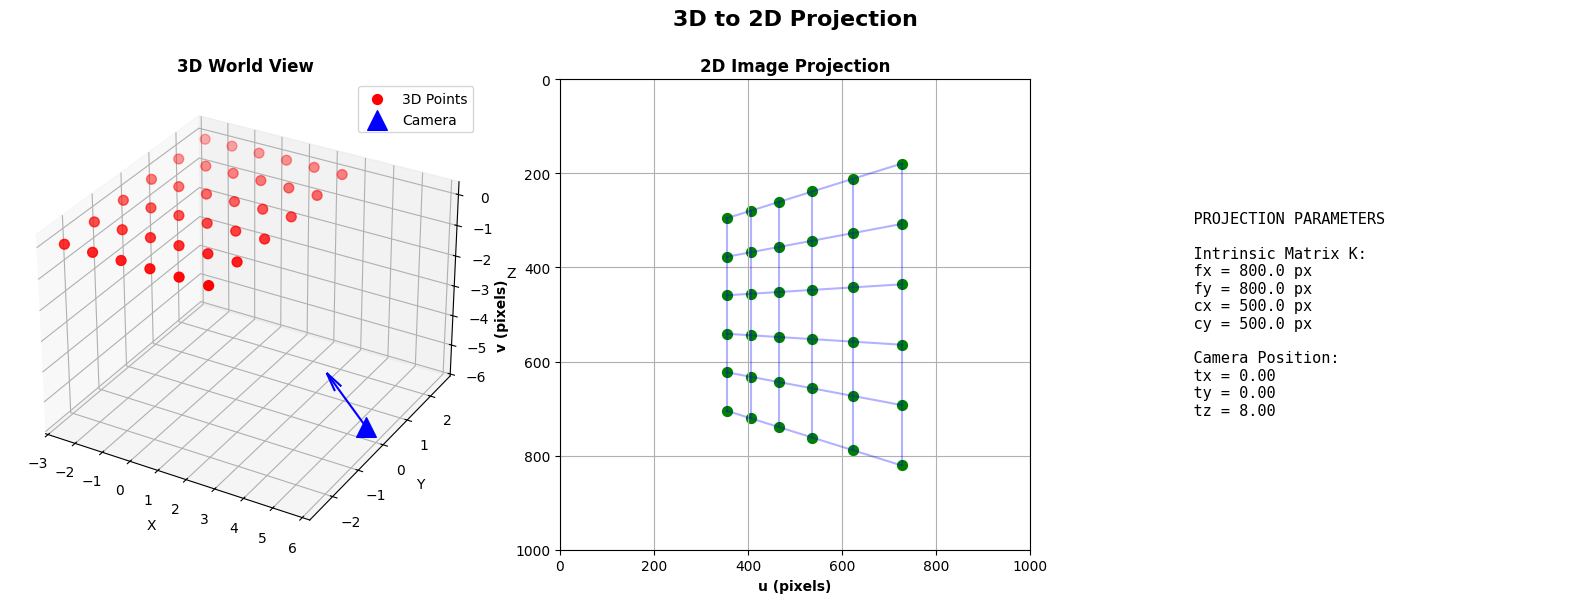

In [116]:
test_projections(checker, fx=800, fy=800, cx=500, cy=500, rotation_deg=(0, 45, 0), translation=(0, 0, 8), img_name="angle2")